# Quality Control Preprocessing for High-Content Screening
The identification of systematic errors and random artifacts in microscopy images from high-content screening (HCS)
experiments is critical for the acquisition of robust datasets. Common image-based aberrations may include out-of-focus
images, debris, and autofluorescing samples which can cause artifacts such as excessive focus blur and image saturation.
Manual inspection of images within a HCS experiment is simply not feasible but poor quality images must be appropriately
identified and addressed as not to degrade otherwise high-quality data.

This quality control (QC) protocol is designed to calculate image-based measurements of QC metrics and apply a trained
machine-learning model to identify, with high-confidence, images which may fail quality control assessment.

The example training dataset provided is generated using a QC pipeline built in CellProfiler, using 177 diverse images
collected over a 2-year period including poor- and good-quality images. The images are raw grayscale TIF images of patient and
patient-derived leukaemic cells, in coculture with mesenchymal stromal cells, assayed across a wide range of experimental
conditions. Image metrics are then used to train an machine learning Voting Classifier model (an ensemble of classifiers).

To apply this protocol to other datasets, it is important to generate unique training data as the model here would be
appropriate only to data acquired under the exact same experimental conditions.



### Generate training set data
First, generate the training data using the `QualityControl.cppipe` CellProfiler pipeline. Remove all the columns which
are not required for training the model including those related to *ExcecutionTime* and *FileName* for example.

Add an additional column named *Pass* which contains a boolean value for whether, upon manual inspection of the training
image, the image is: adequate quality (1); or poor quality (0) and should fail QC checks in the dataset.

### Import the dependencies
Import all dependencies used throughout.

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Import the training dataset to build the model
Import the training data CSV file. We pass the label (target to predict) to an array, remove it from the features (metrics
we use to predict the label), and convert the features to an array for input into the training models.

The <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html' target='_blank'>
train-test-split</a> module of Scikit-learn is used to split the data into training and test data for the purposes
of this demonstration. In practice, the whole training dataset would be used to generate the predictive model for use on
unseen datasets.

In [9]:
# #############################################################################
# Training data

# Load training data
features = pd.read_csv('QC_training.csv')

# Labels are the values we are predicting
labels = np.array(features['Pass'])

# Remove the labels from the feature set
features = features.drop('Pass', axis=1)

feature_list = list(features.columns)
features = np.array(features)

# Use train-test-split on training data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=10)


### Train the models
Fit the training data to an ensemble of classifiers within a VotingClassifier. We can calculate accuracy scores for each
of the individual models and the Voting Classifier; though accuracy alone is a poor metric for assessing performance.

The hyper-parameters of each model were tuned using the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html' target='_blank'>
GridSearchCV</a> module of Scikit-learn, and optimal parameters were chosen. This stage is not shown here but it is recommended to do this on
your own dataset. Random state is set for reproducibility in this demonstration but would not be used in practice.

In [10]:
# #############################################################################
# Training models

# Ensemble classification models. Hyper-parameters of each model were tuned by cross-validation using GridSearchCV.
SEED = 1
rf = RandomForestClassifier(n_estimators=350, min_samples_leaf=2, max_features='log2', random_state=SEED)
knn = KNN(n_neighbors=5)
dt = DecisionTreeClassifier(min_samples_leaf=0.2, max_depth=4, splitter='best', random_state=SEED)
ada = AdaBoostClassifier()
gbb = GradientBoostingClassifier()

classifiers = [('Random Forest', rf),
               ('K Nearest Neighbours', knn),
               ('Classification Tree', dt),
               ('AdaBoost Classifier', ada),
               ('Gradient Boosting Classifier', gbb)]

# Fit each model to the training set, predict on the test set, and calculate accuracy
for clf_name, clf in classifiers:
    # Fit clf to the training set
    clf.fit(X_train, y_train)

    # Predict y_pred
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_pred, y_test)

    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))


# Instantiate a VotingClassifier (vc)
vc = VotingClassifier(estimators=classifiers)

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

Random Forest : 0.917
K Nearest Neighbours : 0.861
Classification Tree : 0.889
AdaBoost Classifier : 0.917
Gradient Boosting Classifier : 0.889
Voting Classifier: 0.917


### Assess performance of the trained model
We can use the model trained on the training set to predict if an unseen image within the test set passes or fails QC.
As we, but not the model which has only seen the training-split of the data, know the real prediction we can assess the
performance of the model.

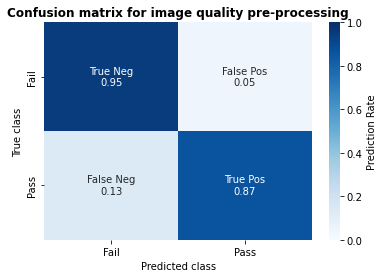

In [11]:
# Calculate and plot confusion matrix
cf_array = confusion_matrix(y_test, y_pred, normalize='true')
cf_group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

cf_labels = [f"{v1}\n{v2}" for v1, v2 in
             zip(cf_group_names, np.around(cf_array.flatten(), 2))]
cf_labels = np.asarray(cf_labels).reshape(2, 2)

fig, ax = plt.subplots()
cf_matrix = sns.heatmap(cf_array, annot=cf_labels, fmt='', vmin=0, vmax=1, cmap='Blues', cbar_kws={'label': 'Prediction Rate'})
cf_matrix.set_xticklabels(['Fail', 'Pass'])
cf_matrix.set_yticklabels(['Fail', 'Pass'], fontdict={'verticalalignment': 'center'})
cf_matrix.set_xlabel('Predicted class')
cf_matrix.set_ylabel('True class')
cf_matrix.set_title('Confusion matrix for image quality pre-processing', weight='bold').set_fontsize('12')
plt.show()

We can also calculate useful statistics to assess the model's performance including sensitivity, specificity, and F1 score.

In [12]:
target_names = ['Pass', 'Fail']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Pass       0.91      0.95      0.93        21
        Fail       0.93      0.87      0.90        15

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.91        36
weighted avg       0.92      0.92      0.92        36



### Predict on a raw dataset
We can now use the trained model to predict whether each image in an unseen dataset passes or fails QC with high confidence.
As with generating the training dataset, the full image dataset should be first pre-processed with the `QualityControl.cppipe`
CellProfiler pipeline. The raw, unedited CSV file from this can then be implemented directly in to this model.

Image numbers and file names are retained as to correctly identify the images within the full dataset which may need to
be filtered out of downstream analyses. Only the images which fail QC checks are exported.

In [13]:
# #############################################################################
# Predict on raw dataset

# Load raw data
raw_df = pd.read_csv('raw_data/raw_data_example.csv')

# Extract image metadata
image_no = np.array(raw_df['ImageNumber'])
image_name = np.array(raw_df['FileName_Image_QC'])

# Extract data 'features' for prediction to array
raw_df = raw_df.loc[:, 'ImageQuality_Correlation_Image_QC_16':'ImageQuality_TotalIntensity_Image_QC']
raw_features = np.array(raw_df)

# Predict on dataset
raw_pred = vc.predict(raw_features)

# Construct df to export predictions
raw_pred_df = pd.DataFrame()
raw_pred_df['ImageNumber'] = image_no
raw_pred_df['FileName'] = image_name
raw_pred_df['QC'] = raw_pred
raw_pred_df['QC'] = raw_pred_df['QC'].replace({1: 'Pass', 0: 'Fail'})
raw_pred_df.set_index('ImageNumber', inplace=True)

# Export failed images
failed_df = raw_pred_df[raw_pred_df['QC'] == 'Fail']
if failed_df.shape[0] > 0:
    failed_df.to_csv('image_QC_failed.csv')
    print(failed_df.head())
else:
    print('There are no images that have not passed QC checks in this dataset.')

                                                    FileName    QC
ImageNumber                                                       
12           LK377-RG-AZD-stitched-Scene-023-C17-C17_ORG.tif  Fail
